# Contingency tables using sparse coordinate matrices

> I like sparseness. There's something about that minimalist feel that can make
> something have an immediate impact and make it unique. I'll probably always
> work with that formula. I just don't know how.
>
> — Britt Daniel, lead singer of *Spoon*.

Many real-world matrices are *sparse*, which means that most of their values are zero.

Using numpy arrays to manipulate sparse matrices wastes a lot of time and energy multiplying many, many values by 0.
Instead, we can use SciPy's `sparse` module to solve these efficiently, examining only non-zero values.
In addition to helping solve these "canonical" sparse matrix problems, `sparse` can be used for problems that are not obviously related to sparse matrices.

One such problem is the comparison of image segmentations.
(Review chapter 3 for a definition of segmentation.)

The code sample motivating this chapter uses sparse matrices twice: First, we
use code nominated by Andreas Mueller to compute a *contingency matrix* that
counts the correspondence of labels between two segmentations. Then, with
suggestions from Jaime Fernández del Río and Warren Weckesser, we use that
contingency matrix to compute the *variation of information*, which measures
the differences between segmentations.

In [1]:
def variation_of_information(x, y):
    # compute contingency matrix, aka joint probability matrix
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # compute marginal probabilities, converting to 1D array
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # use sparse matrix linear algebra to compute VI
    # first, compute the inverse diagonal matrices
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # then, compute the entropies
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # return the sum of these
    return float(hygx + hxgy)

> **Python 3.5 pro-tip! {.callout}**
>
> The `@` symbols in the above paragraph represent the *matrix multiplication*
> operator, and were introduced in Python 3.5 in 2015. This is one of the most
> compelling arguments to use Python 3 for scientific programmers: they enable
> the programming of linear algebra algorithms using code that remains very
> close to the original mathematics. Compare the above:
>
> `hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)`
>
> with the equivalent Python 2 code:
>
> `hygx = px.dot(xlog1x(Px_inv.dot(Pxy)).sum(axis=1))`
>
> By using the `@` operator to stay closer to mathematical notation, we
> can avoid implementation errors and produce code that is much easier to read.
>
> Actually, SciPy's authors knew this long before the `@` operator was
> introduced, and actually altered the meaning of the
> `*` operator when the inputs are SciPy matrices. Available in Python
> 2.7, it lets us produce nice, readable code like the above:
>
> `hygx = -px * xlog(Px_inv * Pxy).sum(axis=1)`
>
> But there is a huge catch: this code will behave differently when `px` or
> `Px_inv` are SciPy matrices than when they are not! If `Px_inv` and `Pxy` are
> NumPy arrays, `*` produces the element-wise multiplication, while if they are
> SciPy matrices, it produces the matrix product! As you can imagine, this is
> the source of a great many errors, and much of the SciPy community has
> abandoned this use in favor of the uglier but unambiguous `.dot` method.
>
> Python 3.5's `@` operator gives us the best of both worlds!

## Contingency tables

But let's start simple and work our way up to segmentations.

Suppose you just started working as a data scientist at email startup Spam-o-matic.
You are tasked with building a detector for spam email.
You encode the detector outcome as a numeric value, 0 for not spam and 1 for spam.

If you have a set of 10 emails to classify, you end up with a vector of *predictions*:

In [2]:
import numpy as np
pred = np.array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

You can check how well you've done by comparing it to a vector of *ground truth*, classifications obtained by inspecting each message by hand.

In [3]:
gt = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Now, classification is hard for computers, so the values in `pred` and `gt` don't match up exactly.
At positions where `pred` is 0 and `gt` is 0, the prediction has correctly identified a message as non-spam.
This is called a *true negative*.
Conversely, at positions where both values are 1, the predictor has correctly identified a spam message, and found a *true positive*.

Then, there are two kinds of errors.
If we let a spam message (where `gt` is 1) through to the user's inbox (`pred` is 0), we've made a *false negative* error.
If we predict a legitimate message (`gt` is 0) to be spam (`pred` is 1), we've made a *false positive* prediction.
(An email from the director of my scientific institute once landed in my spam folder. The reason? His announcement of a postdoc talk competition started with "You could win &#36;500!")

If we want to measure how well we are doing, we have to count the above kinds of errors using a *contingency matrix*.
(This is also sometimes called a confusion matrix. The name is apt.)
For this, we place the prediction labels along the rows and the ground truth labels along the columns.
Then we count the number of times they correspond.
So, for example, since there are 4 true positives (where `pred` and `gt` are both 1), the matrix will have a value of 3 at position (1, 1).

Generally:

$$C_{i, j} = \sum_k{\mathbb{I}(p_k = i) \mathbb{I}(g_k = j)}$$

Here's an intuitive, but inefficient way of building the above:

In [4]:
def confusion_matrix(pred, gt):
    cont = np.zeros((2, 2))
    for i in [0, 1]:
        for j in [0, 1]:
            cont[i, j] = np.sum((pred == i) & (gt == j))
    return cont

We can check that this gives use the right counts:

In [5]:
confusion_matrix(pred, gt)

array([[3., 1.],
       [2., 4.]])

<!-- exercise begin -->
**Exercise:** Why did we call this inefficient?

<!-- solution begin -->

**Solution:** From chapter 1, you recall that `arr == k` creates an array of
Boolean (`True` or `False`) values of the same size as `arr`. This, as you
might expect, requires a full pass over `arr`. Therefore, in the above
solution, we make a full pass over each of `pred` and `gt` for every
combination of values in `pred` and `gt`. In principle, we can compute `cont`
using just a single pass over both arrays, so these multiple passes are
inefficient.

<!-- solution end -->

<!-- exercise end -->

<!-- exercise begin -->

**Exercise:** Write an alternative way of computing the confusion matrix that only makes a single pass through `pred` and `gt`.

In [6]:
def confusion_matrix1(pred, gt):
    cont = np.zeros((2, 2))
    # your code goes here
    return cont

<!-- solution begin -->

**Solution:** We offer two solutions here, although many are possible.

Our first solution uses Python's built-in `zip` function to pair together
labels from `pred` and `gt`.

In [7]:
def confusion_matrix1(pred, gt):
    cont = np.zeros((2, 2))
    for i, j in zip(pred, gt):
        cont[i, j] += 1
    return cont

Our second solution is to iterate over all possible indices of `pred` and `gt`
and manually grab the corresponding value from each array:

In [8]:
def confusion_matrix1(pred, gt):
    cont = np.zeros((2, 2))
    for idx in range(len(pred)):
        i = pred[idx]
        j = gt[idx]
        cont[i, j] += 1
    return cont

The first option might be considered the more "Pythonic" of the two, but the
second one is easier to speed up by translating and compiling in languages or
tools such as C, Cython, and Numba (which are a topic for another book).

<!-- solution end -->

<!-- exercise end -->

We can make this example a bit more general:
Instead of classifying spam and non-spam, we can classify spam, newsletters,
sales and promotions, mailing lists, and personal email.
That's 5 categories, which we'll label 0 to 4.
The confusion matrix will now be 5-by-5, with matches counted on the diagonal,
and errors counted on the off-diagonal entries.

The definition of the `confusion_matrix` function, above, doesn't extend well
to this larger matrix, because now we must have *twenty-five* passes though the
result and ground truth arrays.
This problem only grows as we add more email categories, such as social media
notifications.

<!-- exercise begin -->

**Exercise:** Write a function to compute the confusion matrix in one pass, as
above, but instead of assuming two categories, infer the number of categories
from the input.

In [9]:
def general_confusion_matrix(pred, gt):
    n_classes = None  # replace `None` with something useful
    # your code goes here
    return cont

<!-- solution begin -->

We merely need to make an initial pass through both input arrays to determine
the maximum label. We then add 1 to it to account for the zero label and
Python's 0-based indexing. We then create the matrix and fill it in the same
way as above:

In [10]:
def general_confusion_matrix(pred, gt):
    n_classes = max(np.max(pred), np.max(gt)) + 1
    cont = np.zeros((n_classes, n_classes))
    for i, j in zip(pred, gt):
        cont[i, j] += 1
    return cont

<!-- solution end -->

<!-- exercise end -->

Your one-pass solution will scale well with the number of classes, but, because
the for-loop runs in the Python interpreter, it will be slow when you have a
large number of documents.
Also, because some classes are easier to mistake for one another, the matrix
will be *sparse*, with many 0 entries.
Indeed, as the number of classes increases, dedicating lots of memory space to
the 0 entries of the contingency matrix is increasingly wasteful.
Instead, we can use the `sparse` module of SciPy, which contains objects to
efficiently represent sparse matrices.

## scipy.sparse data formats

We covered the internal data format of NumPy arrays in Chapter 1.
We hope you agree that it's a fairly intuitive, and, in some sense, inevitable
format to hold n-dimensional array data.
For sparse matrices, there are actually a wide array of possible formats, and
the "right" format depends on the problem you want to solve.
We'll cover the two most commonly-used formats, but for a complete list, see the
comparison table later in the chapter, as well as the online documentation for
`scipy.sparse`.

### COO (COOrdinate) format

Perhaps the most intuitive is the coordinate, or COO, format.
This uses three 1D arrays to represent a 2D matrix $A$.
Each of these arrays has length equal to the number of nonzero values in $A$,
and together they list (i, j, value) coordinates of every entry that is not
equal to 0.

- the `row` and `col` arrays, which together specify the location of each
  non-zero entry (row and column indices, respectively).
- the `data` array, which specifies the *value* at each of those locations.

Every part of the matrix that is not represented by the `(row, col)` pairs is
considered to be 0.
Much more efficient!

So, to represent the matrix:

In [11]:
s = np.array([[ 4,  0, 3],
              [ 0, 32, 0]], dtype=float)

We can do the following:

In [12]:
from scipy import sparse

data = np.array([4, 3, 32], dtype=float)
row = np.array([0, 0, 1])
col = np.array([0, 2, 1])

s_coo = sparse.coo_matrix((data, (row, col)))

The `.toarray()` method of every sparse format in `scipy.sparse` returns a
NumPy array representation of the sparse data.
We can use this to check that we created `s_coo` correctly:

In [13]:
s_coo.toarray()

array([[ 4.,  0.,  3.],
       [ 0., 32.,  0.]])

Identically, we can use the `.A` *property*, which is just like an attribute,
but actually executes a function. `.A` is a particularly dangerous property,
because it can hide a potentially very large operation: the dense version
of a sparse matrix can be orders of magnitude bigger than the sparse matrix
itself, bringing a computer to its knees, in just three keystrokes!

In [14]:
s_coo.A

array([[ 4.,  0.,  3.],
       [ 0., 32.,  0.]])

In this chapter, and elsewhere, we recommend using the `toarray()` method
wherever it does not impair readability, as it more clearly signals a
potentially expensive operation. However, we will use `.A` where it makes
the code more readable by virtue of its brevity (for example, when trying to
implement a sequence of mathematical equations).

<!-- exercise begin -->

**Exercise:** write out the COO representation of the following matrix:

In [15]:
s2 = np.array([[0, 0, 6, 0, 0],
               [1, 2, 0, 4, 5],
               [0, 1, 0, 0, 0],
               [9, 0, 0, 0, 0],
               [0, 0, 0, 6, 7]])

<!-- solution begin -->

**Solution:** We first list the non-zero elements of the array, left-to-right and
top-to-bottom, as if reading a book:

In [16]:
s2_data = np.array([6, 1, 2, 4, 5, 1, 9, 6, 7])

We then list the row indices of those values in the same order:

In [17]:
s2_row = np.array([0, 1, 1, 1, 1, 2, 3, 4, 4])

And finally the column indices:

In [18]:
s2_col = np.array([2, 0, 1, 3, 4, 1, 0, 3, 4])

We can easily check that these produce the right matrix, by checking equality
in both directions:

In [19]:
s2_coo0 = sparse.coo_matrix(s2)
print(s2_coo0.data)
print(s2_coo0.row)
print(s2_coo0.col)

[6 1 2 4 5 1 9 6 7]
[0 1 1 1 1 2 3 4 4]
[2 0 1 3 4 1 0 3 4]


and:

In [20]:
s2_coo1 = sparse.coo_matrix((s2_data, (s2_row, s2_col)))
print(s2_coo1.toarray())

[[0 0 6 0 0]
 [1 2 0 4 5]
 [0 1 0 0 0]
 [9 0 0 0 0]
 [0 0 0 6 7]]


<!-- solution end -->

<!-- exercise end -->

Unfortunately, although the COO format is intuitive, it's not very optimized to
use the minimum amount of memory, or to traverse the array as quickly as
possible during computations.
(Remember from Chapter 1, *data locality* is very important to efficient
computation!)
However, you can look at your COO representation above to help you identify
redundant information:
Notice all those repeated `1`s?

### CSR (Compressed Sparse Row) format

If we use COO to enumerate the nonzero entries row-by-row, rather than in
arbitrary order (which the format allows), we end up with many consecutive,
repeated values in the `row` array.
These can be compressed by indicating the *indices* in `col` where the next row
starts, rather than repeatedly writing the row index.
This is the basis for the *compressed sparse row* or *CSR* format.

Let's work through the example above. In CSR format, the `col` and `data`
arrays are unchanged (but `col` is renamed to `indices`). However, the `row`
array, instead of indicating the rows, indicates *where* in `col` each row
begins, and is renamed to `indptr`, for "index pointer".

So, let's look at `row` and `col` in COO format, ignoring `data`:

In [21]:
row = [0, 1, 1, 1, 1, 2, 3, 4, 4]
col = [2, 0, 1, 3, 4, 1, 0, 3, 4]

Each new row begins at the index where `row` changes.
The 0th row starts at index 0, and the 1st row starts at index 1, but the 2nd
row starts where "2" first appears in `row`, at index 5.
Then, the indices increase by 1 for rows 3 and 4, to 6 and 7.
The final index, indicating the end of the matrix, is the total number of
nonzero values (9).
So:

In [22]:
indptr = [0, 1, 5, 6, 7, 9]

Let's use these hand-computed arrays to build a CSR matrix in SciPy.
We can check our work by comparing the `.A` output from our COO and
CSR representations to the numpy array `s2` that we defined earlier.

In [23]:
data = np.array([6, 1, 2, 4, 5, 1, 9, 6, 7])

coo = sparse.coo_matrix((data, (row, col)))
csr = sparse.csr_matrix((data, col, indptr))

print('The COO and CSR arrays are equal: ',
      np.all(coo.A == csr.A))
print('The CSR and NumPy arrays are equal: ',
      np.all(s2 == csr.A))

The COO and CSR arrays are equal:  True
The CSR and NumPy arrays are equal:  True


The ability to store large, sparse matrices, and perform computations on them,
is incredibly powerful, and can be applied in many domains.

For example,
one can think of the entire web as a large, sparse, $N \times N$ matrix.
Each entry $X_{ij}$ indicates whether web page $i$ links to page $j$.
By normalizing this matrix and solving for its dominant eigenvector,
one obtains the so-called PageRank—one of the numbers Google uses to
order your search results. (You can read more about this in the next chapter.)

As another example, we can represent the human brain as a large $m \times m$
graph, where there are $m$ nodes (positions) in which you
measure activity using an MRI scanner.  After a while of measuring,
correlations can be calculated and entered into a matrix $C_{ij}$.
Thresholding this matrix produces a sparse matrix of ones and zeros. 
The eigenvector corresponding to the second-smallest eigenvalue of this matrix
partitions the $m$ brain areas into subgroups, which, it turns out,
are often related to functional regions of the brain [^Newman]!

[^Newman]: Newman MEJ (2006). Modularity and community structure in networks.
           PNAS 103(23):8577-8582. DOI:10.1073/pnas.0601602103

<div class="landscape">
<table style="font-size: 50%;">
<colgroup>
<col width="2%" />
<col width="11%" />
<col width="20%" />
<col width="20%" />
<col width="12%" />
<col width="10%" />
<col width="11%" />
<col width="10%" />
</colgroup>
<thead>
<tr class="header">
<th align="left"></th>
<th align="left">bsr_matrix</th>
<th align="left">coo_matrix</th>
<th align="left">csc_matrix</th>
<th align="left">csr_matrix</th>
<th align="left">dia_matrix</th>
<th align="left">dok_matrix</th>
<th align="left">lil_matrix</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td align="left"><p>Full name</p></td>
<td align="left"><p>Block Sparse Row</p></td>
<td align="left"><p>Coordinate</p></td>
<td align="left"><p>Compressed Sparse Column</p></td>
<td align="left"><p>Compressed Sparse Row</p></td>
<td align="left"><p>Diagonal</p></td>
<td align="left"><p>Dictionary of Keys</p></td>
<td align="left"><p>Row-based linked-list</p></td>
</tr>
<tr class="even">
<td align="left"><p>Note</p></td>
<td align="left"><p>Similar to CSR</p></td>
<td align="left"><p>Only used to construct sparse matrices, which are then converted to CSC or CSR for further operations.</p></td>
<td align="left"></td>
<td align="left"></td>
<td align="left"></td>
<td align="left"><p>Used to construct sparse matrices incrementally.</p></td>
<td align="left"><p>Used to construct sparse matrices incrementally.</p></td>
</tr>
<tr class="odd">
<td align="left"><p>Use cases</p></td>
<td align="left"><ul>
<li>Storage of dense sub-matrices</li>
<li>Often used in numerical analyses of discretized problems,</li>
<li>such as finite elements, differential equations</li>
</ul></td>
<td align="left"><ul>
<li>Fast and straightforward way of constructing sparse matrices</li>
<li>During construction, duplicate coordinates are summed—useful for, e.g., finite element analysis</li>
</ul></td>
<td align="left"><ul>
<li>Arithmetic operations (supports addition, subtraction, multiplication, division, and matrix power</li>
<li>Efficient column slicing</li>
<li>Fast matrix-vector products (CSR, BSR can be faster, depending on the problem)</li>
</ul></td>
<td align="left"><ul>
<li>Arithmetic operations</li>
<li>Efficient row slicing</li>
<li>Fast matrix-vector products</li>
</ul></td>
<td align="left"><ul>
<li>Arithmetic operations</li>
</ul></td>
<td align="left"><ul>
<li>Changes in sparsity structure are inexpensive</li>
<li>Arithmetic operations</li>
<li>Fast access to individual elements</li>
<li>Efficient conversion to COO (but no duplicates allowed)</li>
</ul></td>
<td align="left"><ul>
<li>Changes in sparsity structure are inexpensive</li>
<li>Flexible slicing</li>
</ul></td>
</tr>
<tr class="even">
<td align="left"><p>Cons</p></td>
<td align="left"></td>
<td align="left"><ul>
<li>No arithmetic operations</li>
<li>No slicing</li>
</ul></td>
<td align="left"><ul>
<li>Slow row slicing (see CSR)</li>
<li>Changes to sparsity structure are expensive (see LIL, DOK)</li>
</ul></td>
<td align="left"><ul>
<li>Slow column slicing (see CSC)</li>
<li>Changes to sparsity structure are expensive (see LIL, DOK)</li>
</ul></td>
<td align="left"><ul>
<li>Sparsity structure limited to values on diagonals</li>
</ul></td>
<td align="left"><ul>
<li>Expensive for arithmetic operations</li>
<li>Slow matrix-vector products</li>
</ul></td>
<td align="left"><ul>
<li>Expensive for arithmetic operations</li>
<li>Slow column slicing</li>
<li>Slow matrix-vector products</li>
</ul></td>
</tr>
</tbody>
</table>
</div>

## Applications of sparse matrices: image transformations

Libraries like scikit-image and SciPy already contain algorithms for
transforming (rotating & warping) images effectively, but what if you
were head of the NumPy Agency for Space Affairs and had to rotate
millions of images streaming in from the newly launched Jupyter
Orbiter?

In such cases, you want to squeeze every ounce of performance from your
computer. It turns out that we can do a lot better than even the optimized C
code in SciPy's `ndimage` if we are repeatedly applying the *same*
transformation.

We'll use the following image from scikit-image as example data:

In [24]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

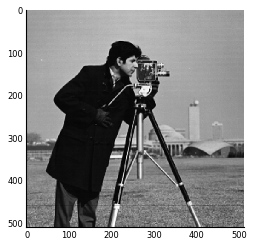

In [25]:
from skimage import data
image = data.camera()
plt.imshow(image);

<!-- caption text="Test image of a cameraman" -->

As a test operation, we'll be rotating the image by 30 degrees. We begin
by defining the transformation matrix, $H$ which, when multiplied with a
coordinate from the input image, $[r, c, 1]$, will give us the
corresponding coordinate in the output, $[r', c', 1]$. (Note: we are using
[homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates),
which have a 1 appended to them and which give greater flexibility when
defining linear transforms.)

In [26]:
angle = 30
c = np.cos(np.deg2rad(angle))
s = np.sin(np.deg2rad(angle))

H = np.array([[c, -s,  0],
              [s,  c,  0],
              [0,  0,  1]])

You can verify that this works by multiplying H with the point (1, 0). A
30-degree counterclockwise rotation around the origin (0, 0) should take us
to point $(\frac{\sqrt{3}}{2}, \frac{1}{2})$:

In [27]:
point = np.array([1, 0, 1])
print(np.sqrt(3) / 2)
print(H @ point)

0.8660254037844386
[0.8660254 0.5       1.       ]


Similarly, applying the 30-degree rotation three times should get us to the
column axis, at point (0, 1). We can see that this works, minus some floating
point approximation error:

In [28]:
print(H @ H @ H @ point)

[2.77555756e-16 1.00000000e+00 1.00000000e+00]


Now, we will build a function that defines a "sparse operator". The goal of
the sparse operator is to take all pixels of the output image, figure out where
they came from in the input image, and do the appropriate (bi-linear)
interpolation (see figure below) to calculate their values. It does this using just
matrix multiplication on the image values, and thus is extremely fast.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/BilinearInterpolation.svg"/>
<!-- caption text="Diagram explaining bilinear interpolation. The value at
point $P$ is estimated as a weighted sum of the values at $Q_{11}$, $Q_{12}$,
$Q_{21}$, $Q_{22}$." -->

Let's look at the function that builds our sparse operator:

In [29]:
from itertools import product

def homography(tf, image_shape):
    """Represent homographic transformation & interpolation as linear operator.

    Parameters
    ----------
    tf : (3, 3) ndarray
        Transformation matrix.
    image_shape : (M, N)
        Shape of input gray image.

    Returns
    -------
    A : (M * N, M * N) sparse matrix
        Linear-operator representing transformation + bilinear interpolation.

    """
    # Invert matrix.  This tells us, for each output pixel, where to
    # find its corresponding input pixel.
    H = np.linalg.inv(tf)

    m, n = image_shape

    # We are going to construct a COO matrix, often called IJK matrix,
    # for which we'll need row coordinates (I), column coordinates (J),
    # and values (K).
    row, col, values = [], [], []

    # For each pixel in the output image...
    for sparse_op_row, (out_row, out_col) in \
            enumerate(product(range(m), range(n))):

        # Compute where it came from in the input image
        in_row, in_col, in_abs = H @ [out_row, out_col, 1]
        in_row /= in_abs
        in_col /= in_abs

        # if the coordinates are outside of the original image, ignore this
        # coordinate; we will have 0 at this position
        if (not 0 <= in_row < m - 1 or
                not 0 <= in_col < n - 1):
            continue

        # We want to find the four surrounding pixels, so that we
        # can interpolate their values to find an accurate
        # estimation of the output pixel value
        # We start with the top, left corner, noting that the remaining
        # points are 1 away in each direction.
        top = int(np.floor(in_row))
        left = int(np.floor(in_col))

        # Calculate the position of the output pixel, mapped into
        # the input image, within the four selected pixels
        # https://commons.wikimedia.org/wiki/File:BilinearInterpolation.svg
        t = in_row - top
        u = in_col - left

        # The current row of the sparse operator matrix is given by the
        # raveled output pixel coordinates, contained in `sparse_op_row`.
        # We will take the weighted average of the four surrounding input
        # pixels, corresponding to four columns. So we need to repeat the row
        # index four times.
        row.extend([sparse_op_row] * 4)

        # The actual weights are calculated according to the bilinear
        # interpolation algorithm, as shown at
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        sparse_op_col = np.ravel_multi_index(
                ([top,  top,      top + 1, top + 1 ],
                 [left, left + 1, left,    left + 1]), dims=(m, n))
        col.extend(sparse_op_col)
        values.extend([(1-t) * (1-u), (1-t) * u, t * (1-u), t * u])

    operator = sparse.coo_matrix((values, (row, col)),
                                 shape=(m*n, m*n)).tocsr()
    return operator

Recall that we apply the sparse operator as follows:

In [30]:
def apply_transform(image, tf):
    return (tf @ image.flat).reshape(image.shape)

Let's try it out!

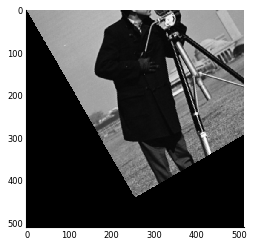

In [31]:
tf = homography(H, image.shape)
out = apply_transform(image, tf)
plt.imshow(out);

<!-- caption text="Rotated cameraman image" -->

There's that rotation!

<!-- exercise begin -->

**Exercise:** The rotation happens around the origin, coordinate (0, 0). But
can you rotate the image around its center?

**Hint:** The transformation matrix for a *translation*, i.e. sliding the image
up/down or left/right, is given by:

$$
H_{tr} =
\begin{bmatrix}
    1 & 0 & t_r \\
    0 & 1 & t_c \\
    0 & 0 &   1
\end{bmatrix}
$$

when you want to move the image $t_r$ pixels down and $t_c$ pixels right.

<!-- solution begin -->

**Solution:** We can *compose* transformations by multiplying them. We know how to rotate
an image about the origin, as well as how to slide it around. So what we will
do is slide the image so that the center is at the origin, rotate it, and then
slide it back.

In [32]:
def transform_rotate_about_center(shape, degrees):
    """Return the homography matrix for a rotation about an image center."""
    c = np.cos(np.deg2rad(angle))
    s = np.sin(np.deg2rad(angle))

    H_rot = np.array([[c, -s,  0],
                      [s,  c,  0],
                      [0,  0,  1]])
    # compute image center coordinates
    center = np.array(image.shape) / 2
    # matrix to center image on origin
    H_tr0 = np.array([[1, 0, -center[0]],
                      [0, 1, -center[1]],
                      [0, 0,          1]])
    # matrix to move center back
    H_tr1 = np.array([[1, 0, center[0]],
                      [0, 1, center[1]],
                      [0, 0,         1]])
    # complete transformation matrix
    H_rot_cent = H_tr1 @ H_rot @ H_tr0

    sparse_op = homography(H_rot_cent, image.shape)

    return sparse_op

We can test that this works:

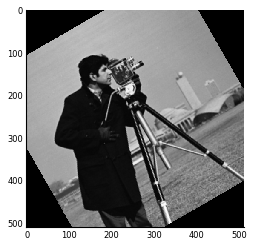

In [33]:
tf = transform_rotate_about_center(image.shape, 30)
plt.imshow(apply_transform(image, tf));

<!-- caption text="Cameraman image rotated about its center" -->

<!-- solution end -->

<!-- exercise end -->

As mentioned above, this sparse linear operator approach to image
transformation is extremely fast.
Let's measure how it performs in comparison to `ndimage`. To make the comparison
fair, we need to tell `ndimage` that we want linear interpolation with `order=1`,
and that we want to ignore pixels outside of the original shape, with
`reshape=False`.

In [34]:
%timeit apply_transform(image, tf)

1.58 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
from scipy import ndimage as ndi
%timeit ndi.rotate(image, 30, reshape=False, order=1)

11.5 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On our machines, we see a speed-up of approximately 10 times.  While
this example does only a rotation, there is no reason why we cannot do
more complicated warping operations, such as correcting for a distorted lens
during imaging, or making people pull funny faces. Once the transform has been
computed, applying it repeatedly is extremely fast, thanks to sparse matrix
algebra.

So now that we've seen a "standard" use of SciPy's sparse matrices, let's have
a look at the out-of-the-box use that inspired this chapter.

## Back to contingency tables

You might recall that we are trying to quickly build a sparse, joint
probability matrix using SciPy's sparse formats. We know that the COO format
stores sparse data as three arrays, containing the row and column coordinates
of nonzero entries, as well as their values. But we can use a little known
feature of COO to obtain our matrix extremely quickly.

Have a look at this data:

In [36]:
row = [0, 0, 2]
col = [1, 1, 2]
dat = [5, 7, 1]
S = sparse.coo_matrix((dat, (row, col)))

Notice that the entry at (row, column) position (0, 1) appears twice: first as
5, and then at 7. What should the matrix value at (0, 1) be? Cases could be
made for both the earliest entry encountered, or the latest, but what was in
fact chosen is the *sum*:

In [37]:
print(S.toarray())

[[ 0 12  0]
 [ 0  0  0]
 [ 0  0  1]]


So, COO format will sum together repeated entries... Which is exactly what we
need to do to make a contingency matrix! Indeed, our task is pretty much done:
we can set `pred` as the rows, `gt` as the columns, and simply 1 as the values.
The ones will get summed together and count the number of times that label $i$
in `pred` occurs together with label $j$ in `gt` at position $i, j$ in the
matrix! Let's try it out:

In [38]:
from scipy import sparse

def confusion_matrix(pred, gt):
    cont = sparse.coo_matrix((np.ones(pred.size), (pred, gt)))
    return cont

To look at a small one, we simply use the `.toarray` method, as above:

In [39]:
cont = confusion_matrix(pred, gt)
print(cont)

  (0, 0)	1.0
  (1, 0)	1.0
  (0, 0)	1.0
  (0, 0)	1.0
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 1)	1.0
  (0, 1)	1.0
  (1, 1)	1.0
  (1, 1)	1.0


In [40]:
print(cont.toarray())

[[3. 1.]
 [2. 4.]]


It works!

<!-- exercise begin -->

**Exercise:** Remember from Chapter 1 that NumPy has built-in tools for
repeating arrays using *broadcasting*. How can you reduce the memory footprint
required for the contingency matrix computation?

**Hint:** Look at the documentation for the function `np.broadcast_to`.

<!-- solution begin -->

**Solution:** The `np.ones` array that we create is read-only: it will only be used as the
values to sum by `coo_matrix`. We can use `broadcast_to` to create a similar
array with only one element, "virtually" repeated n times:

In [41]:
def confusion_matrix(pred, gt):
    n = pred.size
    ones = np.broadcast_to(1., n)  # virtual array of 1s of size n
    cont = sparse.coo_matrix((ones, (pred, gt)))
    return cont

Let's make sure it still works as expected:

In [42]:
cont = confusion_matrix(pred, gt)
print(cont.toarray())

[[3. 1.]
 [2. 4.]]


Boom. Instead of making an array as big as the original data, we just make
one of size 1. As we handle bigger and bigger datasets, such optimizations become
increasingly important.

<!-- solution end -->

<!-- exercise end -->

## Contingency tables in segmentation

You can think of the segmentation of an image in the same way as the classification problem above:
The segment label at each *pixel* is a *prediction* about which *class* the pixel belongs to.
And numpy arrays allow us to do this transparently, because their `.ravel()` method returns a 1D view of the underlying data.

As an example, here's a segmentation of a tiny 3 by 3 image:

In [43]:
seg = np.array([[1, 1, 2],
                [1, 2, 2],
                [3, 3, 3]], dtype=int)

Here’s the ground truth, what some person said was the correct way to segment this image:

In [44]:
gt = np.array([[1, 1, 1],
               [1, 1, 1],
               [2, 2, 2]], dtype=int)

We can think of these two as classifications, just like before. Every pixel is
a different prediction.

In [45]:
print(seg.ravel())
print(gt.ravel())

[1 1 2 1 2 2 3 3 3]
[1 1 1 1 1 1 2 2 2]


Then, like above, the contingency matrix is given by:

In [46]:
cont = sparse.coo_matrix((np.ones(seg.size),
                          (seg.ravel(), gt.ravel())))
print(cont)

  (1, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (3, 2)	1.0
  (3, 2)	1.0


Some indices appear more than once, but we can use the summing feature of the
COO format to confirm that this represents the matrix we want:

In [47]:
print(cont.toarray())

[[0. 0. 0.]
 [0. 3. 0.]
 [0. 3. 0.]
 [0. 0. 3.]]


How do we convert this table into a measure of how well `seg` represents `gt`?
Segmentation is a hard problem, so it's important to measure how well a
segmentation algorithm is doing, by comparing its output to a "ground truth"
segmentation that is manually produced by a human.

But, even this comparison is not an easy task. How do we define how "close" an
automated segmentation is to a ground truth?  We'll illustrate one method, the
*variation of information* or VI (Meila, 2005). This is defined as the answer
to the following question: on average, for a random pixel, if we are given its
segment ID in one segmentation, how much more *information* do we need to
determine its ID in the other segmentation?

Intuitively, if the two segmentations are exactly alike, then knowing the segment
ID in one tells you the segment ID in the other, with no additional information.
But as the segmentations become more different, knowing an ID in one doesn't tell
you the ID in the other without more information.

## Information theory in brief

In order to answer this question, we'll need a quick primer on information
theory. We need to be brief but if you want more information (heh), you should
look at Christopher Olah's stellar blog post,
[Visual Information Theory](https://colah.github.io/posts/2015-09-Visual-Information/).

The basic unit of information is the *bit*, commonly shown as a 0 or 1,
representing an equal probability choice between two options.
This is straightforward: if I want to tell you whether a coin toss landed as
heads or tails, I need one bit, which can take many forms:
a long or short pulse over a telegraph wire (as in Morse code), a light
flashing one of two colors, or a single number taking values 0 or 1.
Importantly, I *always* need one bit, because the outcome of a coin toss is
random.

It turns out that we can extend this concept to *fractional* bits for events
that are *less* random.
Suppose, for example, that you need to transmit whether it rained today in Los
Angeles.
At first glance, it seems that this requires 1 bit as well: 0 for it didn't
rain, 1 for it rained.
However, rain in LA is a rare event, so over time we can actually get away with
transmitting much less information:
Transmit a 0 *occasionally* just to make sure that our communication is still
working, but otherwise simply *assume* that the signal is 0, and send 1 only on
those rare occasions that it rains.

Thus, when two events are *not* equally likely, we need *less* than 1 bit to
represent them.
Generally, we measure this for any random variable $X$ (which could have more
than two possible values) by using the *entropy* function $H$:

$$
\begin{aligned}
H(X) & = \sum_{x}{p_x \log_2\left(\frac{1}{p_x}\right)} \\
     & = -\sum_{x}{p_x \log_2\left(p_x\right)}
\end{aligned}
$$

where the $x$s are possible values of $X$, and $p_x$ is the probability of $X$
taking value $x$.

So, the entropy of a coin toss $T$ that can take values heads ($h$) and tails
($t$) is:

$$
\begin{aligned}
H(T) & = p_h \log_2(1/p_h) + p_t \log_2(1/p_t) \\
     & = 1/2 log_2(2) + 1/2 \log_2(2) \\
     & = 1/2 \cdot 1 + 1/2 \cdot 1 \\
     & = 1
\end{aligned}
$$

The long-term probability of rain on any given day in LA is about 1 in 6, so
the entropy of rain in LA, $R$, taking values rain ($r$) or shine ($s$) is:

$$
\begin{aligned}
H(R) & = p_r \log_2(1/p_r) + p_s \log_2(1/p_s) \\
     & = 1/6 \log_2(6) + 5/6 \log_2(6/5) \\
     & \approx 0.65 \textrm{ bits}
\end{aligned}
$$

A special kind of entropy is the *conditional* entropy.
This is the entropy of a variable *assuming* that you also know something else
about that variable.
For example: what is the entropy of rain *given* that you know the month?
This is written as:

$$
H(R | M) = \sum_{m = 1}^{12}{p(m)H(R | M = m)}
$$

and

$$
\begin{aligned}
H(R | M=m) &= {p_{r|m}\log_2\left(\frac{1}{p_{r|m}}\right) +
               p_{s|m}\log_2\left(\frac{1}{p_{s|m}}\right)} \\
           &= {\frac{p_{rm}}{p_m}\log_2\left(\frac{p_m}{p_{rm}}\right) +
               \frac{p_{sm}}{p_m}\log_2\left(\frac{p_m}{p_{sm}}\right)} \\
           &= {-\frac{p_{rm}}{p_m}\log_2\left(\frac{p_{rm}}{p_{m}}\right) -
               \frac{p_{sm}}{p_m}\log_2\left(\frac{p_{sm}}{p_{m}}\right)}
\end{aligned}
$$

You now have all the information theory you need to understand the variation
of information.
In the above example, events are days, and they have two properties:

- rain/shine
- month

By observing many days, we can build a *contingency matrix*, just like the
ones in the classification examples, measuring the month of a day and whether
it rained.
We're not going to travel to LA to do this (fun though it would be), and
instead we use the historical table below, roughly eyeballed from
[WeatherSpark](https://weatherspark.com/averages/30699/Los-Angeles-California-United-States):

| Month | P(rain)  | P(shine) |
| -----:| -------- | -------- |
|1|0.25|0.75|
|2|0.27|0.73|
|3|0.24|0.76|
|4|0.18|0.82|
|5|0.14|0.86|
|6|0.11|0.89|
|7|0.07|0.93|
|8|0.08|0.92|
|9|0.10|0.90|
|10|0.15|0.85|
|11|0.18|0.82|
|12|0.23|0.77|

The conditional entropy of rain given month is then:

$$
\begin{aligned}
H(R|M) & = -\frac{1}{12} \left( 0.25 \log_2(0.25) +
                                0.75 \log_2(0.75) \right) -
           \frac{1}{12} \left( 0.27 \log_2(0.27) +
                               0.73 \log_2(0.73) \right) \\
       &   - ... -
           \frac{1}{12} \left( 0.23 \log_2(0.23) +
                               0.77 \log_2(0.77) \right) \\
       & \approx 0.626 \textrm{ bits}
\end{aligned}
$$

So, by using the month, we've reduced the randomness of the signal, but not by
much!

We can also compute the conditional entropy of month given rain, which
measures how much information we need to determine the month if we know it
rained.
Intuitively, we know that this is better than going in blind, since it's
more likely to rain in the winter months.

<!-- exercise begin -->

**Exercise:** Compute the conditional entropy of month given rain. What is the
entropy of the month variable? (Ignore the different number of days in a
month.) Which one is greater? (*Hint:* the probabilities in the table are
the conditional probabilities of rain given month.)

In [48]:
prains = np.array([25, 27, 24, 18, 14, 11, 7, 8, 10, 15, 18, 23]) / 100
pshine = 1 - prains
p_rain_g_month = np.column_stack([prains, pshine])
# replace 'None' below with expression for non-conditional contingency
# table. Hint: the values in the table must sum to 1.
p_rain_month = None
# Add your code below to compute H(M|R) and H(M)

<!-- solution begin -->

**Solution:** To obtain the joint probability table, we simply divide the table by its total,
in this case, 12:

In [49]:
print('table total:', np.sum(p_rain_g_month))
p_rain_month = p_rain_g_month / np.sum(p_rain_g_month)

table total: 12.0


Now we can compute the conditional entropy of the month given rain. (This is
like asking: if we know it's raining, how much more information do we need to
know to figure out what month it is, on average?)

In [50]:
p_rain = np.sum(p_rain_month, axis=0)
p_month_g_rain = p_rain_month / p_rain
Hmr = np.sum(p_rain * p_month_g_rain * np.log2(1 / p_month_g_rain))
print(Hmr)

3.5613602410953433


Let's compare that to the entropy of the months:

In [51]:
p_month = np.sum(p_rain_month, axis=1)  # 1/12, but this method is more general
Hm = np.sum(p_month * np.log2(1 / p_month))
print(Hm)

3.584962500721156


So we can see that knowing whether it rained today got us 2 hundredths of a bit
closer to guessing what month it is! Don't bet the farm on that guess.

<!-- solution end -->

<!-- exercise end -->

Together, these two values define the variation of information (VI):

$$
VI(A, B) = H(A | B) + H(B | A)
$$

## Information theory in segmentation: variation of information

Back in the image segmentation context, "days" become "pixels", and "rain" and "month"
become "label in automated segmentation ($S$)" and "label ground truth ($T$)".
Then, the conditional entropy of the automatic segmentation given the ground
truth measures how much additional
information we need to determine a pixel's identity in $S$ if we are told its
identity in $T$.
For example, if every $T$ segment $g$ is split into two equally-sized
segments $a_1$ and $a_2$ in $S$, then $H(S|T) = 1$, because after knowing a
pixel is in $g$, you
still need 1 additional bit to know whether it belongs to $a_1$ or $a_2$.
However, $H(T | S) = 0$, because regardless of whether a pixel is in $a_1$ or
$a_2$, it is guaranteed to be in $g$, so you need no more information than
the segment in S.

So, together, in this case,

$$
VI(S, T) = H(S | T) + H(T | S) = 1 + 0 = 1 \textrm{ bit.}
$$

Here's a simple example:

In [52]:
S = np.array([[0, 1],
              [2, 3]], int)

T = np.array([[0, 1],
              [0, 1]], int)

Here we have two segmentations of a four-pixel image: `S` and `T`. `S`
puts every pixel in its own segment, while `T` puts the left two pixels in
segment 0 and the right two pixels in segment 1.
Now, we make a contingency table of the pixel labels, just as we did with
the spam prediction labels.
The only difference is that the label arrays are 2-dimensional, instead of
the 1D arrays of predictions.
In fact, this doesn't matter:
remember that numpy arrays are actually linear (1D) chunks of data with some
shape and other metadata attached.
As we mentioned before, we can ignore the shape by using the arrays' `.ravel()` method:

In [53]:
S.ravel()

array([0, 1, 2, 3])

Now we can just make the contingency table in the same way as when we were
predicting spam:

In [54]:
cont = sparse.coo_matrix((np.broadcast_to(1., S.size),
                          (S.ravel(), T.ravel())))
cont = cont.toarray()
cont

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In order to make this a table of probabilities, instead of counts, we simply
divide by the total number of pixels:

In [55]:
cont /= np.sum(cont)

Finally, we can use this table to compute the probabilities of labels in *either*
`S` or `T`, using the axis-wise sums:

In [56]:
p_S = np.sum(cont, axis=1)
p_T = np.sum(cont, axis=0)

There is a small kink in writing Python code to compute entropy:
although $0 \log(0)$ is defined to be equal to 0, in Python, it is undefined,
and results in a `nan` (not a number) value:

In [57]:
print('The log of 0 is: ', np.log2(0))
print('0 times the log of 0 is: ', 0 * np.log2(0))

The log of 0 is:  -inf
0 times the log of 0 is:  nan


/Users/squiresrb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/Users/squiresrb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/Users/squiresrb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Therefore, we have to use numpy indexing to mask out the 0 values.
Additionally, we'll need a slightly different strategy depending on whether the
input is a numpy array or a SciPy sparse matrix.
We'll write the following convenience function:

In [58]:
def xlog1x(arr_or_mat):
    """Compute the element-wise entropy function of an array or matrix.

    Parameters
    ----------
    arr_or_mat : numpy array or scipy sparse matrix
        The input array of probabilities. Only sparse matrix formats with a
        `data` attribute are supported.

    Returns
    -------
    out : array or sparse matrix, same type as input
        The resulting array. Zero entries in the input remain as zero,
        all other entries are multiplied by the log (base 2) of their
        inverse.
    """
    out = arr_or_mat.copy()
    if isinstance(out, sparse.spmatrix):
        arr = out.data
    else:
        arr = out
    nz = np.nonzero(arr)
    arr[nz] *= -np.log2(arr[nz])
    return out

Let's make sure it works:

In [59]:
a = np.array([0.25, 0.25, 0, 0.25, 0.25])
xlog1x(a)

array([0.5, 0.5, 0. , 0.5, 0.5])

In [60]:
mat = sparse.csr_matrix([[0.125, 0.125, 0.25,    0],
                         [0.125, 0.125,    0, 0.25]])
xlog1x(mat).A

array([[0.375, 0.375, 0.5  , 0.   ],
       [0.375, 0.375, 0.   , 0.5  ]])

So, the conditional entropy of $S$ given $T$:

In [61]:
H_ST = np.sum(np.sum(xlog1x(cont / p_T), axis=0) * p_T)
H_ST

1.0

And the converse:

In [62]:
H_TS = np.sum(np.sum(xlog1x(cont / p_S[:, np.newaxis]), axis=1) * p_S)
H_TS

0.0

## Converting NumPy array code to use sparse matrices

We used numpy arrays and broadcasting in the above examples, which, as we've
seen many times, is a powerful way to analyze data in Python.
However, for segmentations of complex images, possibly containing thousands of
segments, it rapidly becomes inefficient.
We can instead use `sparse` throughout the calculation, and recast some of the
NumPy magic as linear algebra operations.
This was
[suggested](http://stackoverflow.com/questions/16043299/substitute-for-numpy-broadcasting-using-scipy-sparse-csc-matrix)
to us by Warren Weckesser on StackOverflow.

The linear algebra version efficiently computes a contingency matrix for very
large amounts of data, up to billions of points, and is elegantly concise.

In [63]:
import numpy as np
from scipy import sparse


def invert_nonzero(arr):
    arr_inv = arr.copy()
    nz = np.nonzero(arr)
    arr_inv[nz] = 1 / arr[nz]
    return arr_inv


def variation_of_information(x, y):
    # compute contingency matrix, aka joint probability matrix
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # compute marginal probabilities, converting to 1D array
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # use sparse matrix linear algebra to compute VI
    # first, compute the inverse diagonal matrices
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # then, compute the entropies
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # return the sum of these
    return float(hygx + hxgy)

We can check that this gives the right value (1) for the VI of our toy `S`
and `T`:

In [64]:
variation_of_information(S, T)

1.0

You can see how we use three types of sparse matrices (COO, CSR, and diagonal)
to efficiently solve the entropy calculation in the case of sparse contingency
matrices, where NumPy would be inefficient.
(Indeed, this whole approach was inspired by a Python `MemoryError`!)

## Using variation of information

To finish, let's demonstrate the use of VI to estimate the best possible
automated segmentation of an image.
You may remember our friendly stalking tiger from chapter 3.
(If you don't, you might want to work on your threat-assessment skills!)
Using our skills from chapter 3, we're going to generate a number of possible ways of segmenting the tiger image, and then figure out the best one.

In [65]:
from skimage import io

url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds'
       '/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)

plt.imshow(tiger);

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

<!-- caption text="BSDS tiger image, number 108073" -->


In order to check our image segmentation, we're going to need some ground truth.
It turns out that humans are awesome at detecting tigers (natural selection for the win!), so all we need to do is ask a human to find the tiger.
Luckily, researchers at Berkeley have already asked dozens of humans to look at this image and manually segment it [^bsds].
Let's grab one of the segmentation images from the [Berkeley Segmentation Dataset and Benchmark](https://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/).
It's worth noting that there is quite substantial variation between the segmentations performed by humans.
If you look through the [various tiger segmentations](https://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/dataset/images/color/108073.html), you will see that some humans are more pedantic than others about tracing around the reeds, while others consider the reflections to be objects worth segmenting out from the rest of the water.
We have chosen a segmentation that we like (one with pedantic-reed-tracing, because we are perfectionistic scientist-types.)
But to be clear, we really have no single ground truth!

In [ ]:
from scipy import ndimage as ndi
from skimage import color

human_seg_url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/'
                 'vision/bsds/BSDS300/html/images/human/normal/'
                 'outline/color/1122/108073.jpg')
boundaries = io.imread(human_seg_url)
plt.imshow(boundaries);

<!-- caption text="Human segmentations of the tiger image" -->


Overlaying the tiger image with the human segmentation, we can see that (unsurprisingly) this person does a pretty good job of finding the tiger.
They have also segmented out the river bank, and a tuft of reeds.
Nice job, human #1122!

In [ ]:
human_seg = ndi.label(boundaries > 100)[0]
plt.imshow(color.label2rgb(human_seg, tiger));

<!-- caption text="Human segmentation of the tiger image, overlaid" -->


Now, let's grab our image segmentation code from chapter 3, and see how well a Python does at recognizing a tiger!

In [66]:
# Draw a region adjacency graph (RAG) - all code from Ch3
import networkx as nx
import numpy as np
from skimage.future import graph

def add_edge_filter(values, graph):
    current = values[0]
    neighbors = values[1:]
    for neighbor in neighbors:
        graph.add_edge(current, neighbor)
    return 0. # generic_filter requires a return value, which we ignore!

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    for j in range(labels.ndim):
        fp = np.swapaxes(footprint, j, 0)
        fp[0, ...] = 0  # zero out top of footprint on each axis
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                          mode='nearest', extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.node[n]['total color'] += image[index]
        g.node[n]['pixel count'] += 1
    return g

def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)

In [67]:
# Baseline segmentation
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                        enforce_connectivity=True, sigma=3)
plt.imshow(color.label2rgb(seg, tiger));

NameError: name 'tiger' is not defined

<!-- caption text="Baseline SLIC segmentation of the tiger image" -->

In chapter 3, we set the graph threshold at 80 and sort of hand-waved over the whole thing.
Now we're going to have a closer look at how this threshold impacts our segmentation accuracy.
Let's pop the segmentation code into a function so we can play with it.

In [ ]:
def rag_segmentation(base_seg, image, threshold=80):
    g = build_rag(base_seg, image)
    for n in g:
        node = g.node[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g.node[u]['mean'] - g.node[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)

    threshold_graph(g, threshold)

    map_array = np.zeros(np.max(seg) + 1, int)
    for i, segment in enumerate(nx.connected_components(g)):
        for initial in segment:
            map_array[int(initial)] = i
    segmented = map_array[seg]
    return(segmented)

Let's try a few thresholds and see what happens:

In [ ]:
auto_seg_10 = rag_segmentation(seg, tiger, threshold=10)
plt.imshow(color.label2rgb(auto_seg_10, tiger));

<!-- caption text="Tiger RAG-based segmentation at threshold 10" -->

In [ ]:
auto_seg_40 = rag_segmentation(seg, tiger, threshold=40)
plt.imshow(color.label2rgb(auto_seg_40, tiger));

<!-- caption text="Tiger RAG-based segmentation at threshold 40" -->

Actually, in chapter 3 we did the segmentation a bunch of times with different thresholds and then (because we're human, so we can) picked one that produced a good segmentation.
This is a completely unsatisfying way to program image segmentation.
Clearly, we need a way to automate this.

We can see that the higher threshold seems to producing a better segmentation.
But we have a ground truth, so we can actually put a number to this!
Using all our sparse matrix skills, we can calculate the *variation of information* or VI for each segmentation.

In [ ]:
variation_of_information(auto_seg_10, human_seg)

In [ ]:
variation_of_information(auto_seg_40, human_seg)

The high threshold has a smaller variation of information, so it's a better segmentation!
Now we can calculate the VI for a range of possible thresholds and see which one gives us closes segmentation to the human ground truth.

In [ ]:
# Try many thresholds
def vi_at_threshold(seg, tiger, human_seg, threshold):
    auto_seg = rag_segmentation(seg, tiger, threshold)
    return variation_of_information(auto_seg, human_seg)

thresholds = range(0, 110, 10)
vi_per_threshold = [vi_at_threshold(seg, tiger, human_seg, threshold)
                    for threshold in thresholds]

In [ ]:
plt.plot(thresholds, vi_per_threshold);

<!-- caption text="Segmentation VI as a function of threshold" -->

Unsurprisingly, it turns out that eyeballing it and picking threshold=80, did give us one of the best segmentations.
But now we have a way to automate this process for any image!

In [ ]:
auto_seg = rag_segmentation(seg, tiger, threshold=80)
plt.imshow(color.label2rgb(auto_seg, tiger));

<!-- caption text="Optimal tiger segmentation based on the VI curve" -->

<!-- exercise begin -->

**Exercise:** Segmentation in practice

Try finding the best threshold for a selection of other images from the [Berkeley Segmentation Dataset and Benchmark](https://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/) [^bsds].
Using the mean or median of those thresholds, then go and segment a new image. Did you get a reasonable segmentation?

<!-- exercise end -->

Sparse matrices are an efficient way of representing data with many gaps – a
situation that occurs surprisingly often. After reading this chapter, you'll
probably start noticing opportunities to use them all the time... And you'll
know how.

One particular situation where sparse matrices come extremely handy is in
sparse linear algebra. Read on to the next chapter to find out more!

[^bsds]: P. Arbelaez, M. Maire, C. Fowlkes and J. Malik. IEEE TPAMI, Vol. 33, No. 5, pp. 898-916, May 2011.